## Contrastive Language-Image Pretraining (CLIP) Model

### Setup

In [ ]:
# import dependencies
import os
import random
from pathlib import Path
from typing import Dict, List
import pandas as pd
import numpy as np
from PIL import Image
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import CLIPProcessor, CLIPModel, AutoConfig, get_linear_schedule_with_warmup
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import seaborn as sns
import matplotlib.pyplot as plt

c:\Users\Isabella\Desktop\dsa4213\project\DSA4213-Group26\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# CONFIGURATIONS
TRAIN_TSV = '../data/fakeddit_train.tsv'
VAL_TSV = '../data/fakeddit_val.tsv'
TEST_TSV = '../data/fakeddit_test.tsv'
IMG_DIR = '../data/images/'

MODEL_NAME = 'openai/clip-vit-base-patch32'
OUTPUT_DIR = '../models/clip/'

BATCH_SIZE = 16
WEIGHT_DECAY = 1e-2
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
NUM_LABELS = 3
SEED = 42

# set seed for reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)

In [18]:
# load datasets
train_df = pd.read_csv(TRAIN_TSV, sep='\t')
val_df = pd.read_csv(VAL_TSV, sep='\t')
test_df = pd.read_csv(TEST_TSV, sep='\t')

In [ ]:
# class weighting due to class imbalance
y_train = train_df['3_way_label']

classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float)
class_weights = class_weights.to(DEVICE)

print("Class weights:", class_weights)

# to use this as loss later
criterion = torch.nn.CrossEntropyLoss(weight=class_weights)

Class weights: tensor([0.6042, 9.2801, 0.8083])


### Create Dataset

In [19]:
processor = CLIPProcessor.from_pretrained(MODEL_NAME)

class FakedditDataset(Dataset):
    def __init__(self, df, img_dir, processor, id_col='id', text_col='clean_title', label_col='3_way_label'):
        self.df = df
        self.img_dir = img_dir
        self.processor = processor
        self.id_col = id_col
        self.text_col = text_col
        self.label_col = label_col

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        text = str(row[self.text_col])
        label = int(row[self.label_col])

        # Load image
        img_path = os.path.join(self.img_dir, f"{row[self.id_col]}.jpg")
        if not os.path.exists(img_path):
            raise FileNotFoundError(f"Image not found: {img_path}")
        image = Image.open(img_path).convert("RGB")

        return {"text": text, "image": image, "labels": torch.tensor(label)}

In [20]:
# collate function to handle padding and batching
def collate_fn(batch):
    texts = [item["text"] for item in batch]
    images = [item["image"] for item in batch]
    labels = torch.tensor([item["labels"] for item in batch])

    inputs = processor(
        text=texts,
        images=images,
        padding=True,
        truncation=True,
        return_tensors="pt",
    )
    inputs["labels"] = labels
    return inputs

In [21]:
# create datasets
train_ds = FakedditDataset(train_df, IMG_DIR, processor)
val_ds = FakedditDataset(val_df, IMG_DIR, processor)
test_ds = FakedditDataset(test_df, IMG_DIR, processor)

# create dataloaders
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

### Create CLIP Classification Model

In [22]:
class CLIPClassifier(nn.Module):
    def __init__(self, model_name=MODEL_NAME, num_labels=NUM_LABELS):
        super().__init__()
        self.clip = CLIPModel.from_pretrained(model_name)
        embed_dim = self.clip.config.projection_dim
        self.dropout = nn.Dropout(0.2)
        self.classifier = nn.Linear(embed_dim * 2, num_labels)

    def forward(self, input_ids, attention_mask, pixel_values, labels=None):
        text_feats = self.clip.get_text_features(input_ids=input_ids, attention_mask=attention_mask)
        img_feats = self.clip.get_image_features(pixel_values=pixel_values)
        text_feats = nn.functional.normalize(text_feats, dim=-1)
        img_feats = nn.functional.normalize(img_feats, dim=-1)
        fused = torch.cat([text_feats, img_feats], dim=-1)
        x = self.dropout(fused)
        logits = self.classifier(x)
        return logits

### Evaluation Helper

In [31]:
def evaluate_model(model, data_loader):
    model.eval()
    preds, labels = [], []

    loop = tqdm(data_loader, desc="Evaluating")

    with torch.no_grad():
        for batch in loop:
            batch = {k: v.to(DEVICE) for k, v in batch.items()}
            logits = model(
                input_ids=batch['input_ids'], 
                attention_mask=batch['attention_mask'], 
                pixel_values=batch['pixel_values']
            )
            pred = torch.argmax(logits, dim=1)
            preds.extend(pred.cpu().tolist())
            labels.extend(batch['labels'].cpu().tolist())

    # get metric scores
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='macro')
    precision = precision_score(labels, preds, average='macro', zero_division=0)
    recall = recall_score(labels, preds, average='macro', zero_division=0)

    return {'accuracy': accuracy, 'f1': f1, 'precision': precision, 'recall': recall}


### Fine-Tuning Classifier Head

In [34]:
# training setup
EPOCHS = 5
LEARNING_RATE = 1e-4
model = CLIPClassifier(MODEL_NAME, NUM_LABELS).to(DEVICE)
for param in model.clip.parameters():
    param.requires_grad = False
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=int(0.05 * total_steps), 
    num_training_steps=total_steps
)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {num_params}")

Number of trainable parameters: 3075


#### Training Loop

In [35]:
best_f1 = 0.0
train_losses = []
val_accuracies = []
val_f1s = []

# training loop
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0.0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")

    for batch in loop:
        batch = {k: v.to(DEVICE) for k, v in batch.items()}
        optimizer.zero_grad()
        logits = model(
            input_ids=batch['input_ids'], 
            attention_mask=batch['attention_mask'], 
            pixel_values=batch['pixel_values']
        )
        loss = criterion(logits, batch['labels'])
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{EPOCHS}: loss={avg_loss:.4f}")

    # evaluate on validation set
    val_metrics = evaluate_model(model, val_loader)
    val_accuracies.append(val_metrics['accuracy'])
    val_f1s.append(val_metrics['f1'])
    print(f"Epoch {epoch+1}/{EPOCHS}: val_accuracy={val_metrics['accuracy']:.4f}, val_f1={val_metrics['f1']:.4f}")

    # save best model
    if val_metrics['f1'] > best_f1:
        best_f1 = val_metrics['f1']
        torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, 'best_model_classifier.pt'))
        print("Best model saved.")

Epoch 1/5: 100%|██████████| 1887/1887 [1:26:22<00:00,  2.75s/it, loss=0.913]


Epoch 1/5: loss=1.0112


Evaluating: 100%|██████████| 236/236 [10:56<00:00,  2.78s/it]


Epoch 1/5: val_accuracy=0.7829, val_f1=0.7867
Best model saved.


Epoch 2/5: 100%|██████████| 1887/1887 [1:27:40<00:00,  2.79s/it, loss=0.854]


Epoch 2/5: loss=0.8649


Evaluating: 100%|██████████| 236/236 [11:18<00:00,  2.87s/it]


Epoch 2/5: val_accuracy=0.7898, val_f1=0.8005
Best model saved.


Epoch 3/5: 100%|██████████| 1887/1887 [1:25:36<00:00,  2.72s/it, loss=0.779]


Epoch 3/5: loss=0.7830


Evaluating: 100%|██████████| 236/236 [10:40<00:00,  2.71s/it]


Epoch 3/5: val_accuracy=0.7882, val_f1=0.7965


Epoch 4/5: 100%|██████████| 1887/1887 [1:23:12<00:00,  2.65s/it, loss=0.657]


Epoch 4/5: loss=0.7382


Evaluating: 100%|██████████| 236/236 [10:20<00:00,  2.63s/it]


Epoch 4/5: val_accuracy=0.7887, val_f1=0.7963


Epoch 5/5: 100%|██████████| 1887/1887 [1:24:35<00:00,  2.69s/it, loss=0.556]


Epoch 5/5: loss=0.7184


Evaluating: 100%|██████████| 236/236 [11:04<00:00,  2.81s/it]

Epoch 5/5: val_accuracy=0.7895, val_f1=0.7980


In [38]:
print(f"Train Losses: {train_losses}")
print(f"Validation Accuracies: {val_accuracies}")
print(f"Validation F1 Scores: {val_f1s}")

Train Losses: [1.011162258483268, 0.8648932673151555, 0.7829566248428524, 0.7381689366551386, 0.7183909997873099]
Validation Accuracies: [0.7828738069989396, 0.7897667020148462, 0.7881760339342524, 0.7887062566277837, 0.7895015906680806]
Validation F1 Scores: [0.7867456066573705, 0.80054727452314, 0.7964946192692001, 0.796256372158369, 0.7980197142284259]


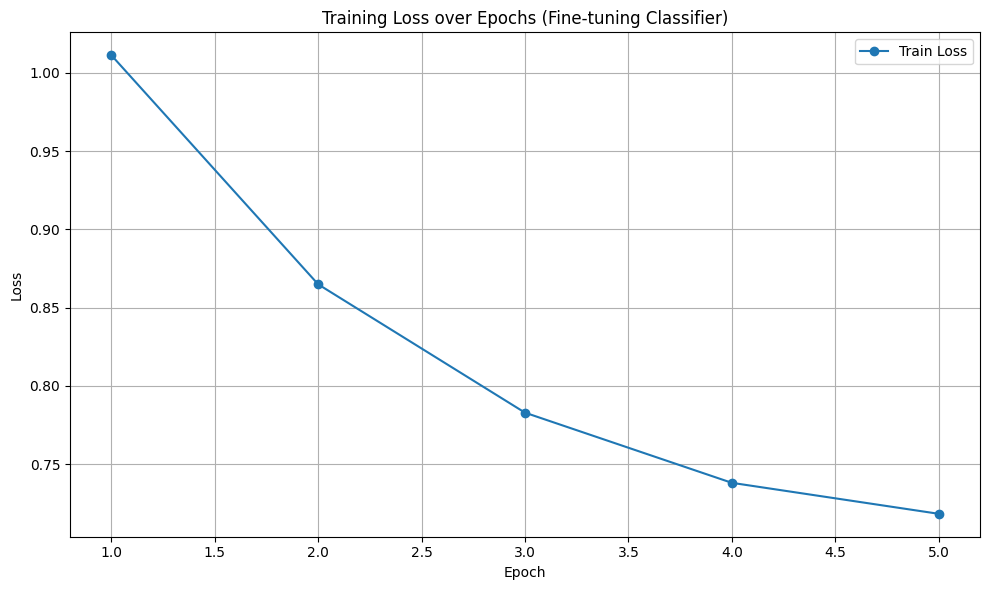

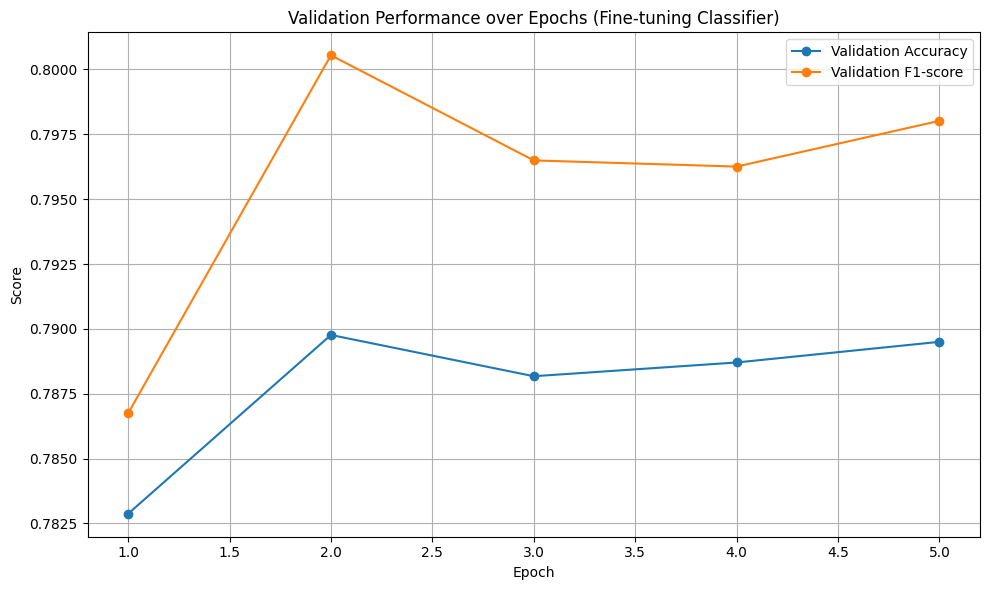

In [42]:
# plot training loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS+1), train_losses, marker='o', label='Train Loss')
plt.title('Training Loss over Epochs (Fine-tuning Classifier)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# plot validation accuracy and f1 
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS+1), val_accuracies, marker='o', label='Validation Accuracy')
plt.plot(range(1, EPOCHS+1), val_f1s, marker='o', label='Validation F1-score')
plt.title('Validation Performance over Epochs (Fine-tuning Classifier)')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#### Evaluation on Test Set

In [40]:
# compute evaluation metrics
model.load_state_dict(torch.load(os.path.join(OUTPUT_DIR, 'best_model_classifier.pt'), map_location=DEVICE))
test_metrics = evaluate_model(model, test_loader)
print("Test Metrics (Fine-tuning Classifier):", test_metrics)

Evaluating: 100%|██████████| 236/236 [12:18<00:00,  3.13s/it]

Test Metrics (Fine-tuning Classifier): {'accuracy': 0.7932679565332627, 'f1': 0.8094134885171563, 'precision': 0.8088928495539917, 'recall': 0.8115657133961909}


In [43]:
# load best model
model.load_state_dict(torch.load(os.path.join(OUTPUT_DIR, 'best_model_classifier.pt'), map_location=DEVICE))
model.eval()

# define label names
label_names = ['True', 'Misleading', 'Fake']

# collect predictions and labels
all_preds, all_labels = [], []
loop = tqdm(test_loader, desc='Testing')
with torch.no_grad():
    for batch in loop:
        batch = {k: v.to(DEVICE) for k, v in batch.items()}
        logits = model(batch["input_ids"], batch["attention_mask"], batch["pixel_values"])
        preds = torch.argmax(logits, dim=-1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch["labels"].cpu().numpy())

Testing: 100%|██████████| 236/236 [11:36<00:00,  2.95s/it]


In [44]:
# print classification report
report = classification_report(all_labels, all_preds, target_names=label_names, digits=4)
print('\n=== Classification Report (Fine-tuning Classifier) ===\n')
print(report)


=== Classification Report (Fine-tuning Classifier) ===

              precision    recall  f1-score   support

        True     0.7993    0.8492    0.8235      2082
  Misleading     0.8489    0.8741    0.8613       135
        Fake     0.7785    0.7114    0.7435      1556

    accuracy                         0.7933      3773
   macro avg     0.8089    0.8116    0.8094      3773
weighted avg     0.7925    0.7933    0.7918      3773



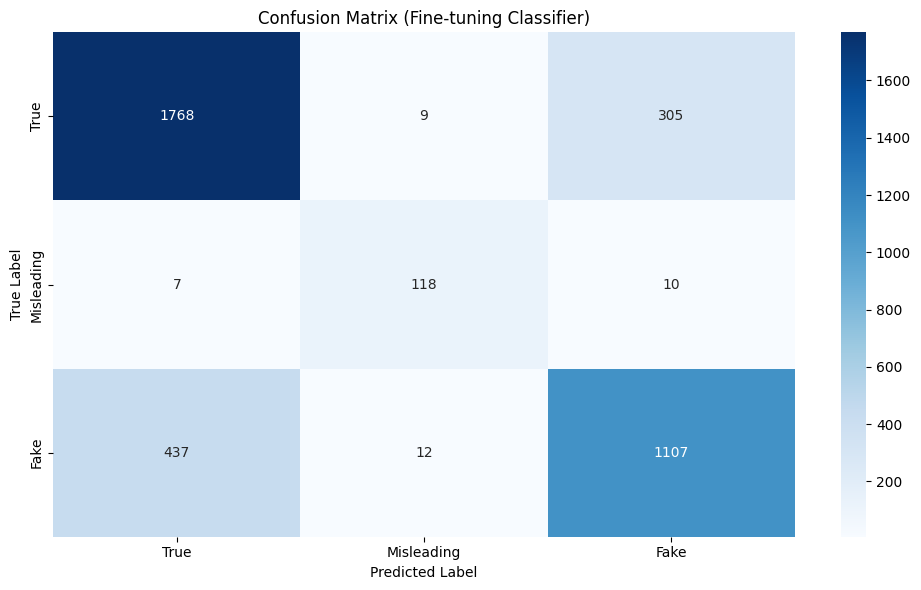

In [45]:
# plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Fine-tuning Classifier)')
plt.tight_layout()
plt.show()

In [47]:
# binarize labels for ROC and precision-recall curves
y_true_bin = label_binarize(all_labels, classes=[0, 1, 2])
n_classes = y_true_bin.shape[1]

# get prediction probabilities
all_probs = []
loop = tqdm(test_loader, desc='Collecting probabilities')
with torch.no_grad():
    for batch in loop:
        batch = {k: v.to(DEVICE) for k, v in batch.items()}
        logits = model(batch["input_ids"], batch["attention_mask"], batch["pixel_values"])
        probs = torch.softmax(logits, dim=-1)
        all_probs.extend(probs.cpu().numpy())

all_probs = np.array(all_probs)

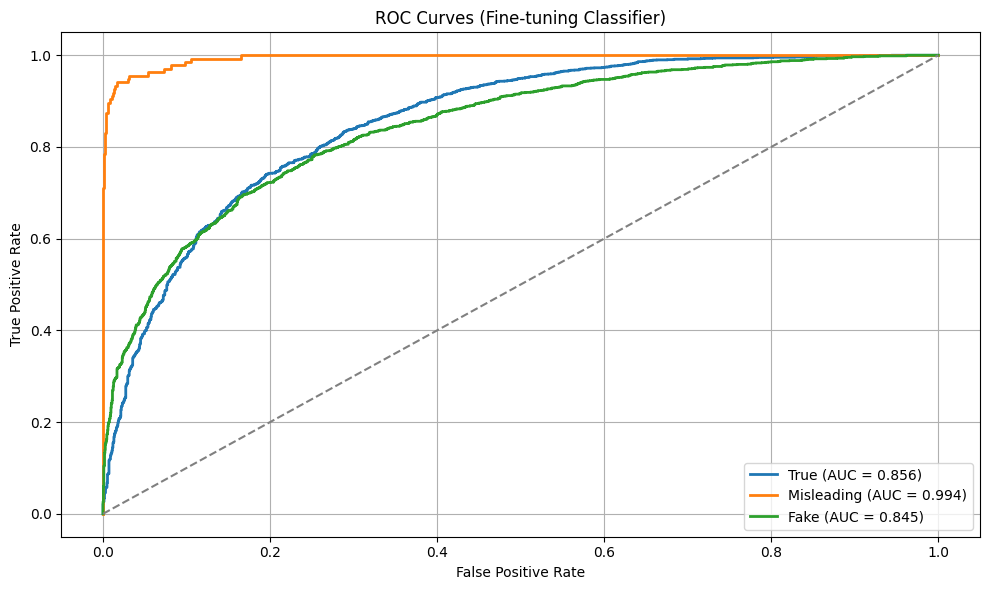

In [48]:
# plot ROC curves
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 6))
for i, name in enumerate(label_names):
    plt.plot(fpr[i], tpr[i], lw=2, label=f"{name} (AUC = {roc_auc[i]:.3f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Fine-tuning Classifier)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

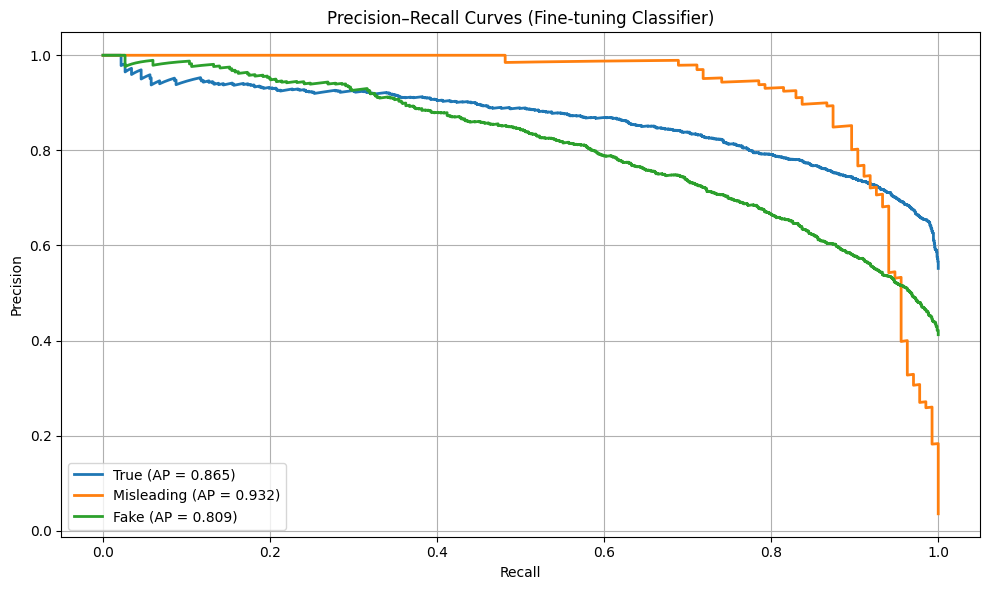

In [49]:
# plot precision-recall curves
precision, recall, avg_precision = {}, {}, {}
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], all_probs[:, i])
    avg_precision[i] = average_precision_score(y_true_bin[:, i], all_probs[:, i])

plt.figure(figsize=(10, 6))
for i, name in enumerate(label_names):
    plt.plot(recall[i], precision[i], lw=2, label=f"{name} (AP = {avg_precision[i]:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves (Fine-tuning Classifier)")
plt.legend(loc="lower left")
plt.grid(True)
plt.tight_layout()
plt.show()

Total misclassified samples: 780 / 3773


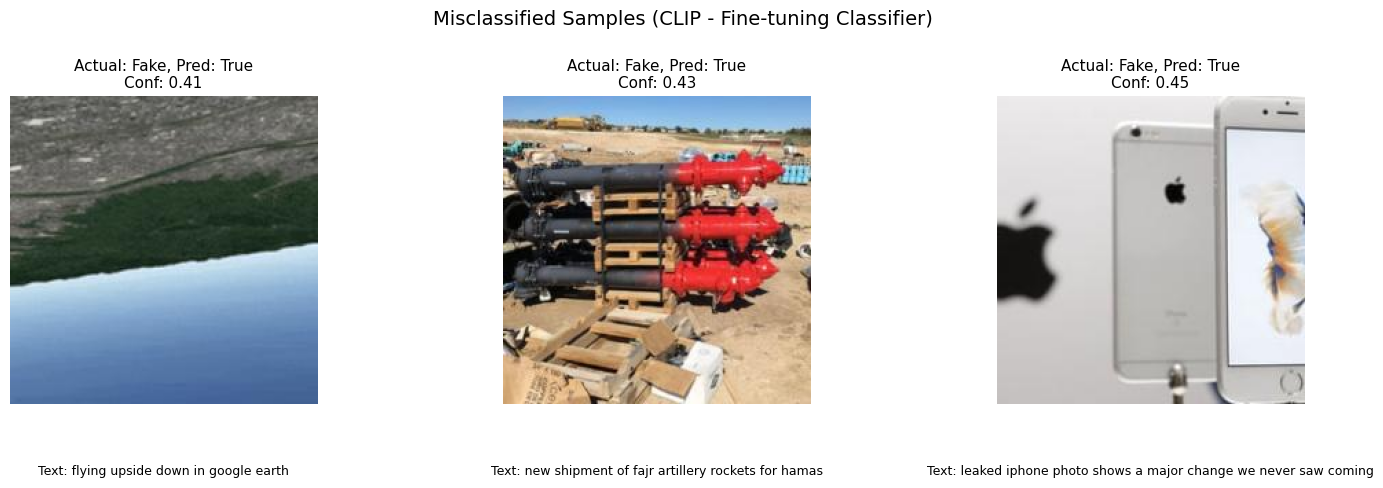

In [62]:
# collect misclassified examples
misclassified_indices = [i for i, (true, pred) in enumerate(zip(all_labels, all_preds)) if true != pred]
print(f"Total misclassified samples: {len(misclassified_indices)} / {len(all_labels)}")

# randomly sample a few error cases
num_samples = min(3, len(misclassified_indices))
sampled_errors = random.sample(misclassified_indices, num_samples)

# plot misclassified samples
plt.figure(figsize=(15, 8))

for idx, sample_idx in enumerate(sampled_errors, 1):
    row = test_df.iloc[sample_idx]
    image_id = row["id"]
    image_path = os.path.join(IMG_DIR, f"{image_id}.jpg")

    if not os.path.exists(image_path):
        continue  
    
    image = Image.open(image_path).convert("RGB")

    true_label = label_names[all_labels[sample_idx]]
    pred_label = label_names[all_preds[sample_idx]]
    probs = all_probs[sample_idx]
    confidence = np.max(probs)

    text = str(row.get("clean_title", ""))
    if len(text) > 120:
        text = text[:117] + "..."

    plt.subplot(2, 3, idx)
    plt.imshow(image)
    plt.axis("off")
    plt.title(
        f"Actual: {true_label}, Pred: {pred_label}\nConf: {confidence:.2f}",
        fontsize=11,
        color="black"
    )
    plt.text(
        0.5, -0.2, 
        f"Text: {text}",
        fontsize=9,
        ha="center",
        va="top",
        wrap=True,
        transform=plt.gca().transAxes
    )

plt.suptitle("Misclassified Samples (CLIP - Fine-tuning Classifier)", fontsize=14, y=1)
plt.tight_layout()
plt.show()

### Full Fine-Tuning

In [64]:
# training setup
EPOCHS = 3
LEARNING_RATE = 1e-5
model = CLIPClassifier(MODEL_NAME, NUM_LABELS).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=int(0.05 * total_steps), 
    num_training_steps=total_steps
)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {num_params}")

Number of trainable parameters: 151280388


#### Training Loop

In [ ]:
best_f1_full = 0.0
train_losses_full = []
val_accuracies_full= []
val_f1s_full = []

# training loop
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0.0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")

    for batch in loop:
        batch = {k: v.to(DEVICE) for k, v in batch.items()}
        optimizer.zero_grad()
        logits = model(
            input_ids=batch['input_ids'], 
            attention_mask=batch['attention_mask'], 
            pixel_values=batch['pixel_values']
        )
        loss = criterion(logits, batch['labels'])
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(train_loader)
    train_losses_full.append(avg_loss)
    print(f"Epoch {epoch+1}/{EPOCHS}: loss={avg_loss:.4f}")

    # evaluate on validation set
    val_metrics_full = evaluate_model(model, val_loader)
    val_accuracies_full.append(val_metrics_full['accuracy'])
    val_f1s_full.append(val_metrics_full['f1'])
    print(f"Epoch {epoch+1}/{EPOCHS}: val_accuracy={val_metrics_full['accuracy']:.4f}, val_f1={val_metrics_full['f1']:.4f}")

    # save best model
    if val_metrics_full['f1'] > best_f1_full:
        best_f1_full = val_metrics_full['f1']
        torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, 'best_model_full.pt'))
        print("Best model saved.")

Epoch 1/3: 100%|██████████| 1887/1887 [4:28:36<00:00,  8.54s/it, loss=0.806]  


Epoch 1/3: loss=0.7516


Evaluating: 100%|██████████| 236/236 [10:31<00:00,  2.68s/it]


Epoch 1/3: val_accuracy=0.7884, val_f1=0.7433
Best model saved.


Epoch 2/3: 100%|██████████| 1887/1887 [4:23:48<00:00,  8.39s/it, loss=0.479]  


Epoch 2/3: loss=0.5158


Evaluating: 100%|██████████| 236/236 [10:31<00:00,  2.68s/it]


Epoch 2/3: val_accuracy=0.8367, val_f1=0.8382
Best model saved.


Epoch 3/3: 100%|██████████| 1887/1887 [4:24:41<00:00,  8.42s/it, loss=0.326]  


Epoch 3/3: loss=0.3876


Evaluating: 100%|██████████| 236/236 [10:24<00:00,  2.65s/it]


Epoch 3/3: val_accuracy=0.8364, val_f1=0.8433
Best model saved.


In [ ]:
print(f"Train Losses: {train_losses_full}")
print(f"Validation Accuracies: {val_accuracies_full}")
print(f"Validation F1 Scores: {val_f1s_full}")

Train Losses: [0.7515862656132405, 0.515786146653286, 0.3875764135841851]
Validation Accuracies: [0.7884290177238544, 0.8367458012160655, 0.8364390125258112]
Validation F1 Scores: [0.7432718521847097, 0.8381855620727139, 0.8433128985352126]


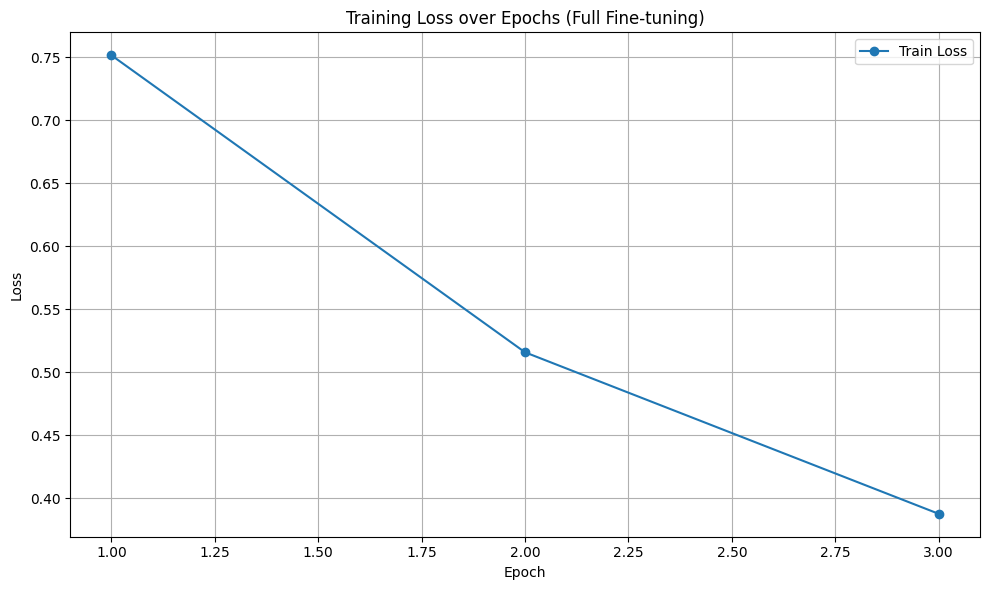

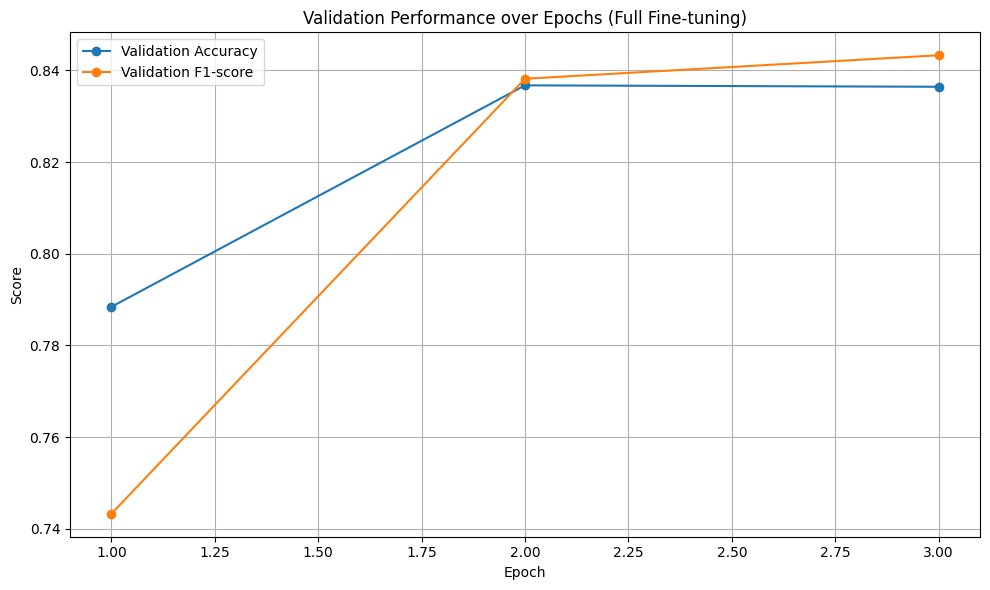

In [92]:
# plot training loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS+1), train_losses_full, marker='o', label='Train Loss')
plt.title('Training Loss over Epochs (Full Fine-tuning)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# plot validation accuracy and f1 
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS+1), val_accuracies_full, marker='o', label='Validation Accuracy')
plt.plot(range(1, EPOCHS+1), val_f1s_full, marker='o', label='Validation F1-score')
plt.title('Validation Performance over Epochs (Full Fine-tuning)')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#### Evaluation on Test Set

In [78]:
# compute evaluation metrics
model.load_state_dict(torch.load(os.path.join(OUTPUT_DIR, 'best_model_full.pt'), map_location=DEVICE))
test_metrics = evaluate_model(model, test_loader)
print("Test Metrics (Full Fine-tuning):", test_metrics)

Evaluating: 100%|██████████| 236/236 [15:50<00:00,  4.03s/it]

Test Metrics (Full Fine-tuning): {'accuracy': 0.8404452690166976, 'f1': 0.8448066901873599, 'precision': 0.8313762412044859, 'recall': 0.8608280804999403}


In [79]:
# load best model
model.load_state_dict(torch.load(os.path.join(OUTPUT_DIR, 'best_model_full.pt'), map_location=DEVICE))
model.eval()

# define label names
label_names = ['True', 'Misleading', 'Fake']

# collect predictions and labels
all_preds, all_labels = [], []
loop = tqdm(test_loader, desc='Testing')
with torch.no_grad():
    for batch in loop:
        batch = {k: v.to(DEVICE) for k, v in batch.items()}
        logits = model(batch["input_ids"], batch["attention_mask"], batch["pixel_values"])
        preds = torch.argmax(logits, dim=-1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch["labels"].cpu().numpy())

Testing: 100%|██████████| 236/236 [16:07<00:00,  4.10s/it]


In [80]:
# print classification report
report = classification_report(all_labels, all_preds, target_names=label_names, digits=4)
print('\n=== Classification Report (Full Fine-tuning) ===\n')
print(report)


=== Classification Report (Full Fine-tuning) ===

              precision    recall  f1-score   support

        True     0.8835    0.8305    0.8562      2082
  Misleading     0.8188    0.9037    0.8592       135
        Fake     0.7918    0.8483    0.8191      1556

    accuracy                         0.8404      3773
   macro avg     0.8314    0.8608    0.8448      3773
weighted avg     0.8434    0.8404    0.8410      3773



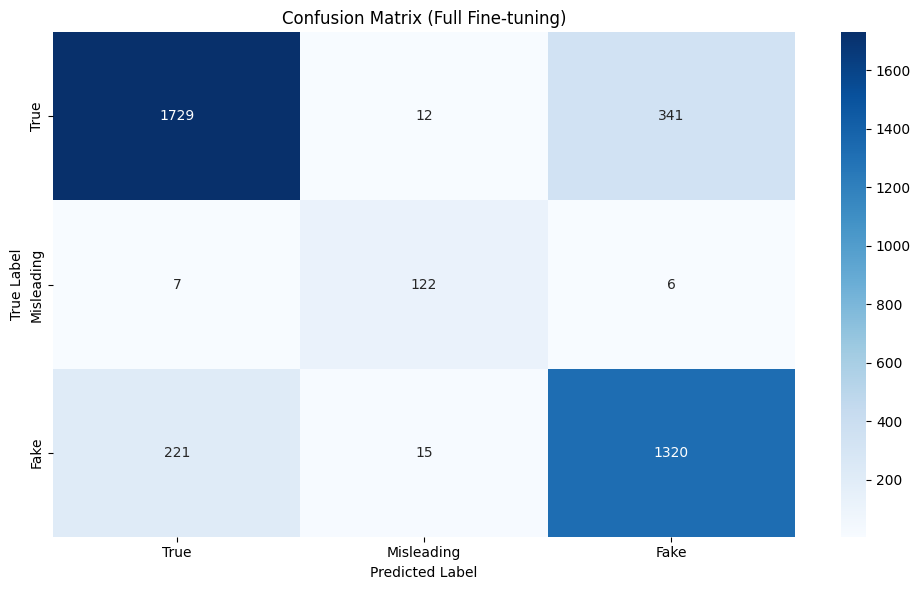

In [81]:
# plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Full Fine-tuning)')
plt.tight_layout()
plt.show()

In [82]:
# binarize labels for ROC and precision-recall curves
y_true_bin = label_binarize(all_labels, classes=[0, 1, 2])
n_classes = y_true_bin.shape[1]

# get prediction probabilities
all_probs = []
loop = tqdm(test_loader, desc='Collecting probabilities')
with torch.no_grad():
    for batch in loop:
        batch = {k: v.to(DEVICE) for k, v in batch.items()}
        logits = model(batch["input_ids"], batch["attention_mask"], batch["pixel_values"])
        probs = torch.softmax(logits, dim=-1)
        all_probs.extend(probs.cpu().numpy())

all_probs = np.array(all_probs)

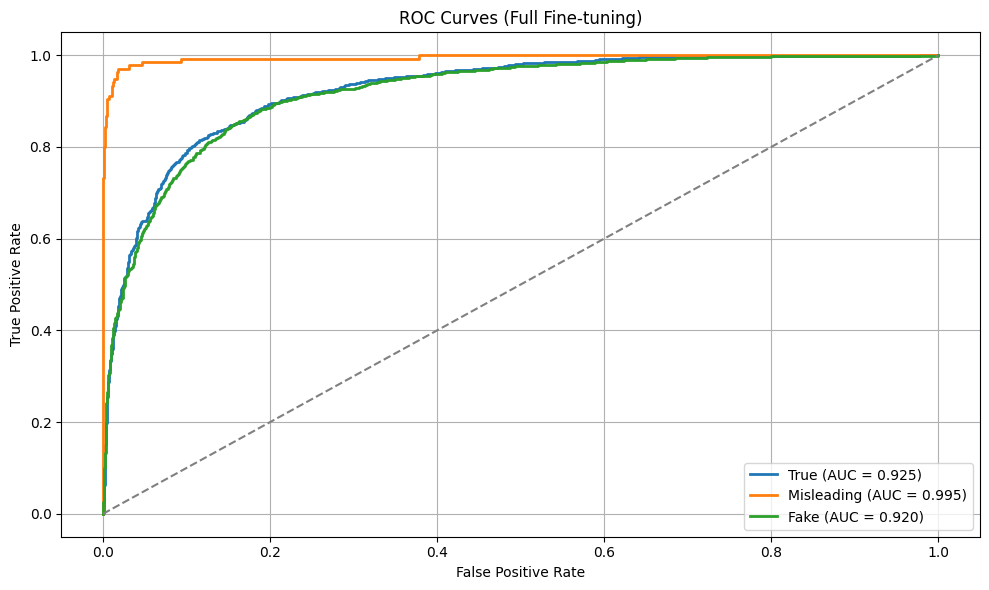

In [83]:
# plot ROC curves
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 6))
for i, name in enumerate(label_names):
    plt.plot(fpr[i], tpr[i], lw=2, label=f"{name} (AUC = {roc_auc[i]:.3f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Full Fine-tuning)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

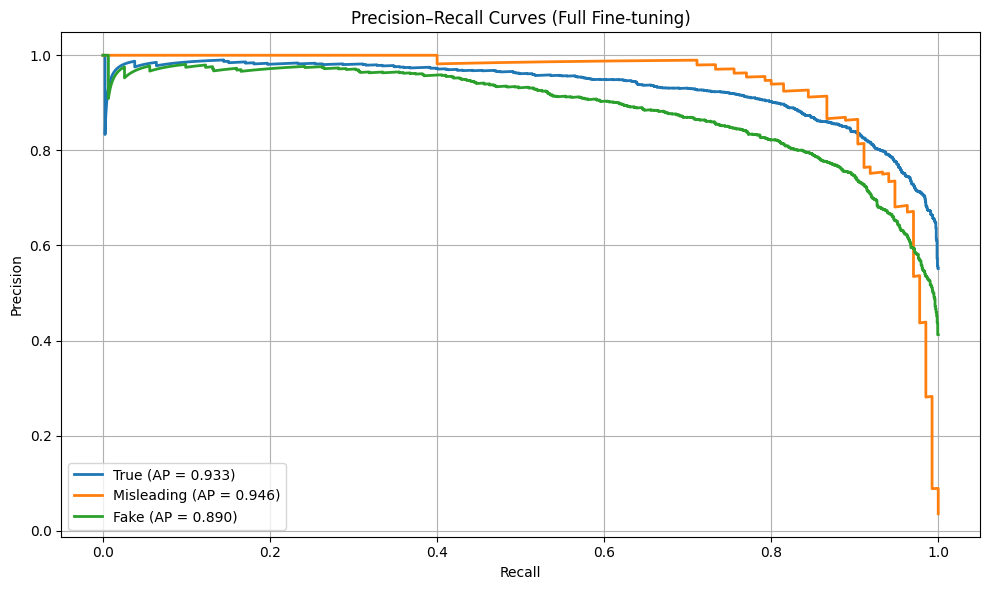

In [84]:
# plot precision-recall curves
precision, recall, avg_precision = {}, {}, {}
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], all_probs[:, i])
    avg_precision[i] = average_precision_score(y_true_bin[:, i], all_probs[:, i])

plt.figure(figsize=(10, 6))
for i, name in enumerate(label_names):
    plt.plot(recall[i], precision[i], lw=2, label=f"{name} (AP = {avg_precision[i]:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves (Full Fine-tuning)")
plt.legend(loc="lower left")
plt.grid(True)
plt.tight_layout()
plt.show()

Total misclassified samples: 602 / 3773


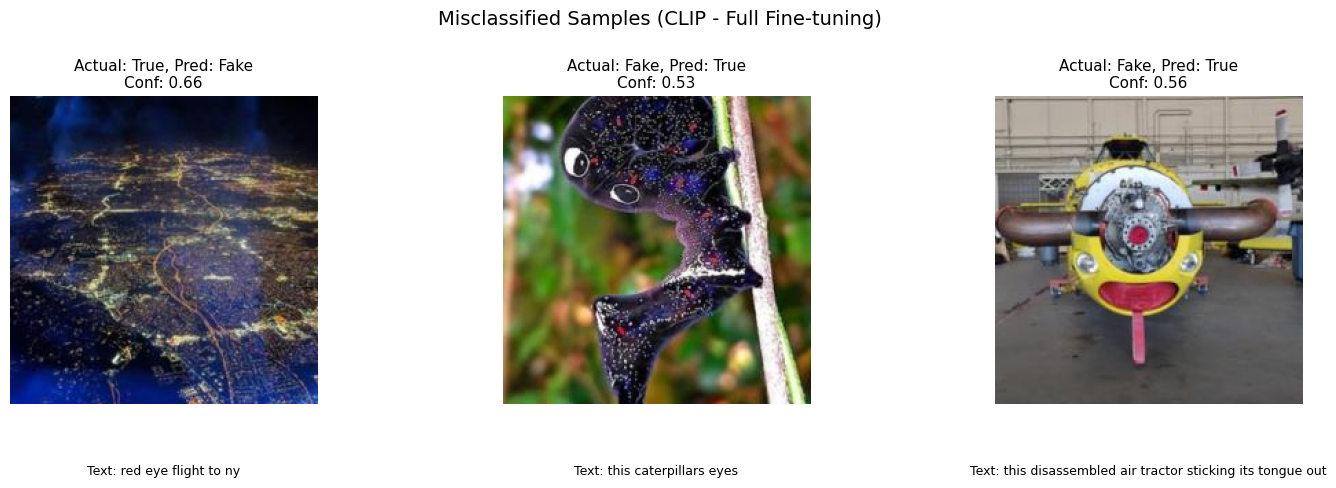

In [88]:
# collect misclassified examples
misclassified_indices = [i for i, (true, pred) in enumerate(zip(all_labels, all_preds)) if true != pred]
print(f"Total misclassified samples: {len(misclassified_indices)} / {len(all_labels)}")

# randomly sample a few error cases
num_samples = min(3, len(misclassified_indices))
sampled_errors = random.sample(misclassified_indices, num_samples)

# plot misclassified samples
plt.figure(figsize=(15, 8))

for idx, sample_idx in enumerate(sampled_errors, 1):
    row = test_df.iloc[sample_idx]
    image_id = row["id"]
    image_path = os.path.join(IMG_DIR, f"{image_id}.jpg")

    if not os.path.exists(image_path):
        continue  
    
    image = Image.open(image_path).convert("RGB")

    true_label = label_names[all_labels[sample_idx]]
    pred_label = label_names[all_preds[sample_idx]]
    probs = all_probs[sample_idx]
    confidence = np.max(probs)

    text = str(row.get("clean_title", ""))
    if len(text) > 120:
        text = text[:117] + "..."

    plt.subplot(2, 3, idx)
    plt.imshow(image)
    plt.axis("off")
    plt.title(
        f"Actual: {true_label}, Pred: {pred_label}\nConf: {confidence:.2f}",
        fontsize=11,
        color="black"
    )
    plt.text(
        0.5, -0.2, 
        f"Text: {text}",
        fontsize=9,
        ha="center",
        va="top",
        wrap=True,
        transform=plt.gca().transAxes
    )

plt.suptitle("Misclassified Samples (CLIP - Full Fine-tuning)", fontsize=14, y=1)
plt.tight_layout()
plt.show()